In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
from tensorflow.keras import backend as K
import cv2

TF version: 2.2.0
Hub version: 0.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [3]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [6]:
data_dir =r"C:\Users\BG\Desktop\PlantVillage"

In [11]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 4122 images belonging to 15 classes.
Found 16516 images belonging to 15 classes.


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(pixels, pixels, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(train_generator.num_classes,  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])


In [14]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
516/516 [==============================] - 1022s 2s/step - loss: 1.9670 - accuracy: 0.4350 - val_loss: 1.4053 - val_accuracy: 0.6855
Epoch 2/10
516/516 [==============================] - 1022s 2s/step - loss: 1.3033 - accuracy: 0.7182 - val_loss: 1.0974 - val_accuracy: 0.8130
Epoch 3/10
516/516 [==============================] - 1027s 2s/step - loss: 1.0493 - accuracy: 0.8309 - val_loss: 1.0072 - val_accuracy: 0.8369
Epoch 4/10
516/516 [==============================] - 1022s 2s/step - loss: 0.9195 - accuracy: 0.8881 - val_loss: 0.8716 - val_accuracy: 0.9077
Epoch 5/10
516/516 [==============================] - 28415s 55s/step - loss: 0.8279 - accuracy: 0.9279 - val_loss: 0.8346 - val_accuracy: 0.9172
Epoch 6/10
516/516 [==============================] - 1101s 2s/step - loss: 0.7685 - accuracy: 0.9523 - val_loss: 0.7960 - val_accuracy: 0.9368
Epoch 7/10
516/516 [==============================] - 1078s 2s/step - loss: 0.7291 - accuracy: 0.9682 - val_loss: 0.7531 - val_accurac

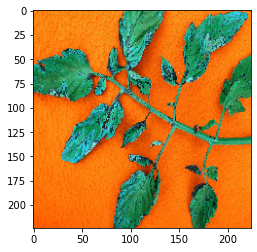

In [15]:
import cv2
image=cv2.imread(f"{data_dir}/bacterial spot2.jpg")
image=cv2.resize(image, (pixels, pixels)) 
image=image/255

plt.imshow(image)


In [16]:

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [17]:
img_tensor=np.expand_dims(image, axis=0)
activations = activation_model.predict(img_tensor)

In [18]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)


(1, 222, 222, 32)


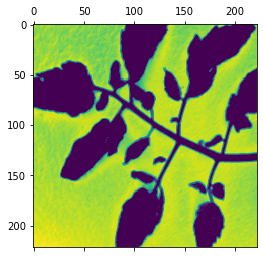

In [19]:
#Plotting the fourth channel of the activation of the first layer of the original model
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

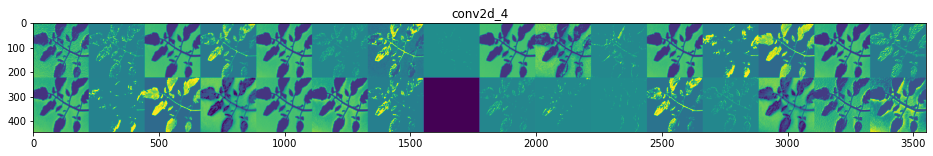

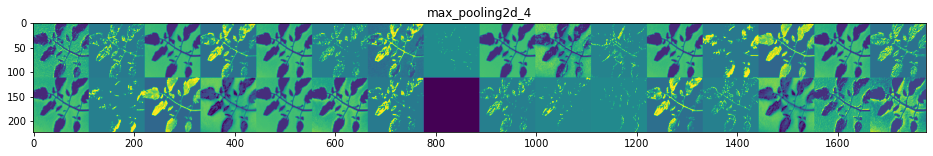

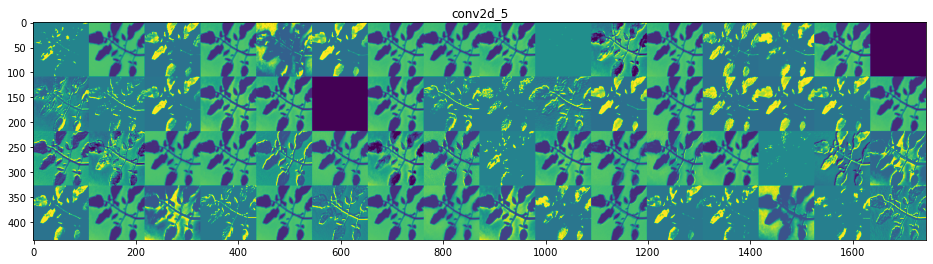

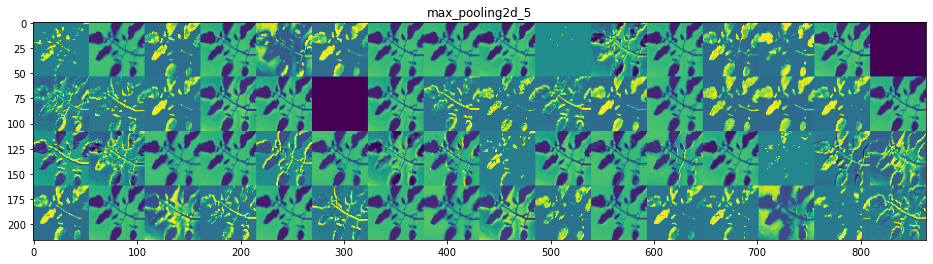

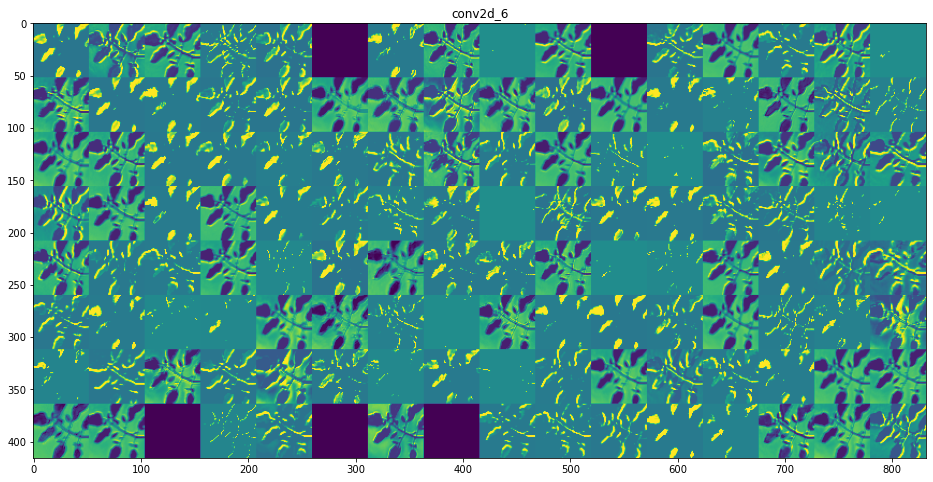

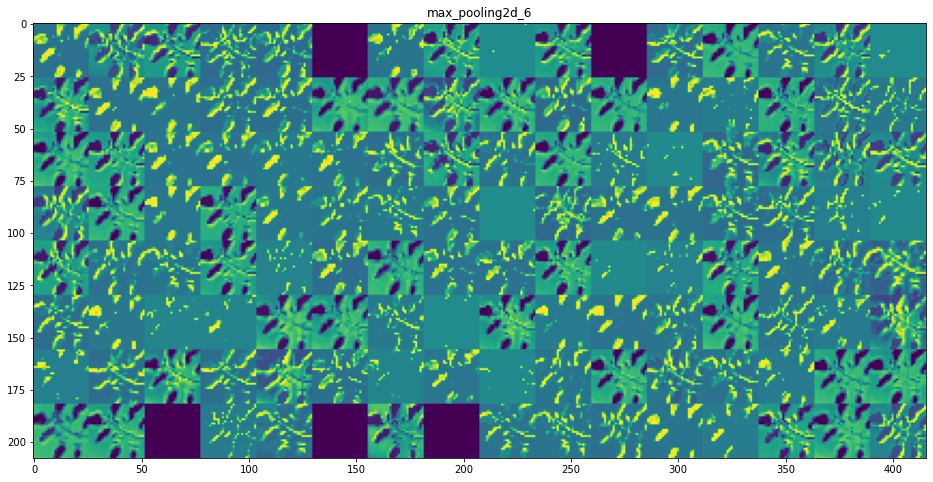

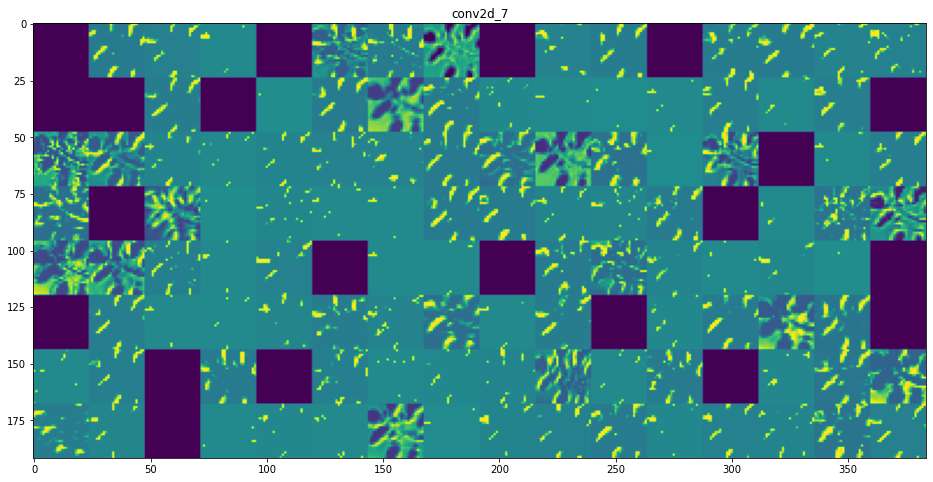

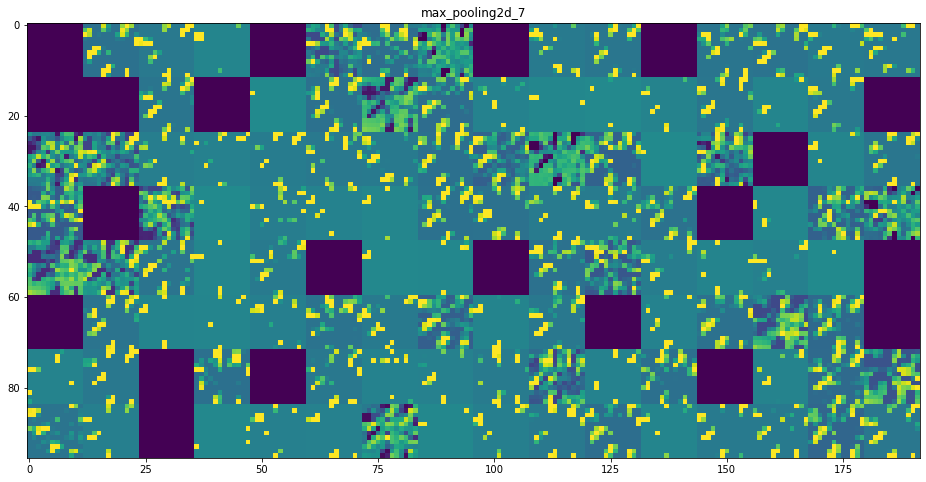

In [25]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [22]:
layer_names

['conv2d_4',
 'max_pooling2d_4',
 'conv2d_5',
 'max_pooling2d_5',
 'conv2d_6',
 'max_pooling2d_6',
 'conv2d_7',
 'max_pooling2d_7']

(1, 24, 24)


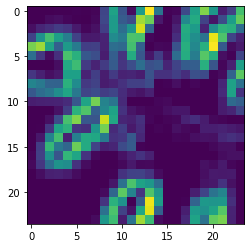

In [29]:
#tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.
conv_layer = model.get_layer("conv2d_7")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)
hm=np.squeeze(heatmap)
hm.shape
plt.imshow(hm)

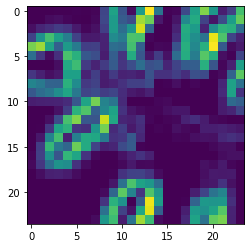

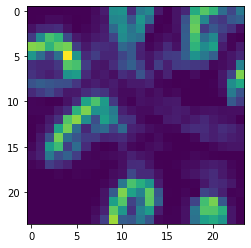

In [57]:
plt.imshow(hm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

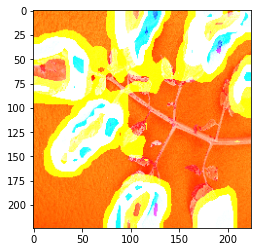

In [30]:

hm = cv2.resize(hm, (image.shape[1], image.shape[0]))
hm = np.uint8(255 * hm)
hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
superimposed_img = hm * 0.4 + image
plt.imshow(superimposed_img)
cv2.imwrite(f"{data_dir}/masked2.jpg", superimposed_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


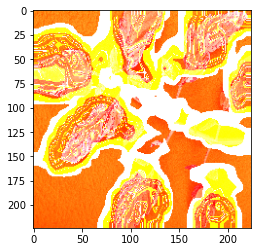